基礎的なnlpを行います。  
- mecabによる形態素解析  
- nlplotによる分析  

参考 : https://boxcode.jp/nlplot%E3%81%8C%E5%87%84%E3%81%84%EF%BC%81%E8%87%AA%E7%84%B6%E8%A8%80%E8%AA%9E%E3%82%92%E5%8F%AF%E8%A6%96%E5%8C%96%E3%83%BB%E5%88%86%E6%9E%90%E3%81%A7%E3%81%8D%E3%82%8Bpython%E3%83%A9%E3%82%A4

# params

In [2]:
class CFG:
    dic_dir = "/opt/conda/lib/python3.10/site-packages/unidic/dicdir" # MeCabの辞書が格納されている所
    filename_base = "jaran_fb"

# import/install

## install

In [3]:
# !git clone https://github.com/megagonlabs/jrte-corpus # sample dataのダウンロード

In [4]:
# !pip install mecab-python3

In [5]:
# !pip install unidic
# !python -m unidic download # MeCabで使用する辞書のinstall

In [6]:
# !pip install wordcloud

In [7]:
## https://qiita.com/kenichiro_nishioka/items/d58f9f08eb659171fd8a
## https://self-development.info/ipaexgothic%E3%81%AB%E3%82%88%E3%82%8Bmatplotlib%E3%81%AE%E6%97%A5%E6%9C%AC%E8%AA%9E%E5%8C%96%E3%80%90python%E3%80%91/
# ! sudo apt update
# ! sudo apt install fontconfig

In [8]:
# ! sudo apt install fonts-ipaexfont

## (Y/n)の選択があるので、ターミナルで実行

## import

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import MeCab 
import pandas as pd
from matplotlib import font_manager

In [10]:
# import sys
# import codecs
# sys.stdout = codecs.getwriter('shift_jis')(sys.stdout)

In [11]:
import matplotlib
print(matplotlib.matplotlib_fname())

/opt/conda/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc


# データロード  
今回はサンプルとしてじゃらんの宿評価データセットを用います。

In [12]:
df = pd.read_csv('./jrte-corpus/data/pn.tsv', delimiter='\t', header=None, names = ["id", "pn", "text", "categ", "categ_2"])
df = df[["id", "text"]]

In [13]:
df

,id,text
0,pn17q00001,出張でお世話になりました。
1,pn17q00002,朝食は普通でした。
2,pn17q00003,また是非行きたいです。
3,pn17q00004,また利用したいと思えるホテルでした。
4,pn17q00005,駅から近くて便利でした。
...,...,...
5548,pn17q05964,スクランブルエッグにとても大きな殻が入っていてざりざりして気持ちが悪く未だに思い出します。
5549,pn17q05965,何組か食事してましたが、明らかにレストランではないスペース。
5550,pn17q05967,静かで居心地も良いしまた行きたい宿になりましたが、一点だけ残念だったのが夕食の海鮮舟盛りです。
5551,pn17q05968,チェックインして、部屋に入るとベッドルームの照明の位置もわかりにくく、大変な思いをしました。


In [14]:
df["text"][0]

'出張でお世話になりました。'

# 形態素解析  
MeCabによる形態素解析を実施します。

In [15]:
def pick_words(sample):
    '''
    文章を文字列形式で入力し、形態素解析した結果を品詞ごとにoutputします。  
    input
    sample[str] 形態素解析したい文字列

    output
    dict[str] 形態素解析された単語リスト
     dict.norm 
        sampleの中に含まれる名詞
     dict.verb
        sampleの中に含まれる動詞
     dict.adverb
        sampleの中に含まれる形容詞

    '''
    wakati = MeCab.Tagger("-d "+ CFG.dic_dir)
    node = wakati.parseToNode(sample)
  

    norm   = []
    adverb = []
    verb   = []

    while node:
    #名詞のみリストに格納する
        if node.feature.split(',')[0] == '名詞':
            norm.append(node.surface)
        #他の品詞を取得したければ、elifで追加する
        elif node.feature.split(',')[0] == '形容詞':
            adverb.append(node.surface)
        elif node.feature.split(',')[0] == '動詞':
            verb.append(node.surface)
        #    wordlist.append(node.surface)
        node = node.next

    return {
      "norm": norm,
      "adverb":adverb,
      "verb":verb
    }

In [16]:
# nlplotにinputできる形にデータを成形

df["norms"] = df["text"].apply(lambda x: pick_words(x)["norm"])
df["adverbs"] = df["text"].apply(lambda x: pick_words(x)["adverb"])
df["verbs"] = df["text"].apply(lambda x: pick_words(x)["verb"])
df["words"] = df["text"].apply(lambda x: pick_words(x)["norm"] + pick_words(x)["adverb"]) # 動詞まで含めるとみにくくなる（「する」など一般的すぎる動詞が邪魔になる。）ので除外

In [17]:
df = df[["text", "words"]]
df.head()

,text,words
0,出張でお世話になりました。,"[出張, 世話]"
1,朝食は普通でした。,"[朝食, 普通]"
2,また是非行きたいです。,[]
3,また利用したいと思えるホテルでした。,"[利用, ホテル]"
4,駅から近くて便利でした。,"[駅, 便利, 近く]"


In [18]:
plt.rcParams["font.family"] = "IPAexGothic"

# word cloudの作成

In [19]:
!ls ~/.cache/matplotlib/

fontlist-v330.json


In [20]:
!rm ~/.cache/matplotlib/fontlist-v330.json

In [21]:
from wordcloud import WordCloud

In [22]:
whole_text = ""
for i in df.iterrows():
    for j in i[1]["words"]:
        whole_text += j + " " 

In [23]:
# フォントファイルの場所を確認
! fc-list | grep 'IPA'

/usr/share/fonts/opentype/ipaexfont-gothic/ipaexg.ttf: IPAexGothic,IPAexゴシック:style=Regular
/usr/share/fonts/opentype/ipaexfont-mincho/ipaexm.ttf: IPAexMincho,IPAex明朝:style=Regular
/usr/share/fonts/truetype/fonts-japanese-mincho.ttf: IPAexMincho,IPAex明朝:style=Regular
/usr/share/fonts/truetype/fonts-japanese-gothic.ttf: IPAexGothic,IPAexゴシック:style=Regular


In [24]:
result = WordCloud(
    width=480, 
    height=320, 
    background_color="white",
    font_path='/usr/share/fonts/opentype/ipaexfont-gothic/ipaexg.ttf'
).generate(whole_text)

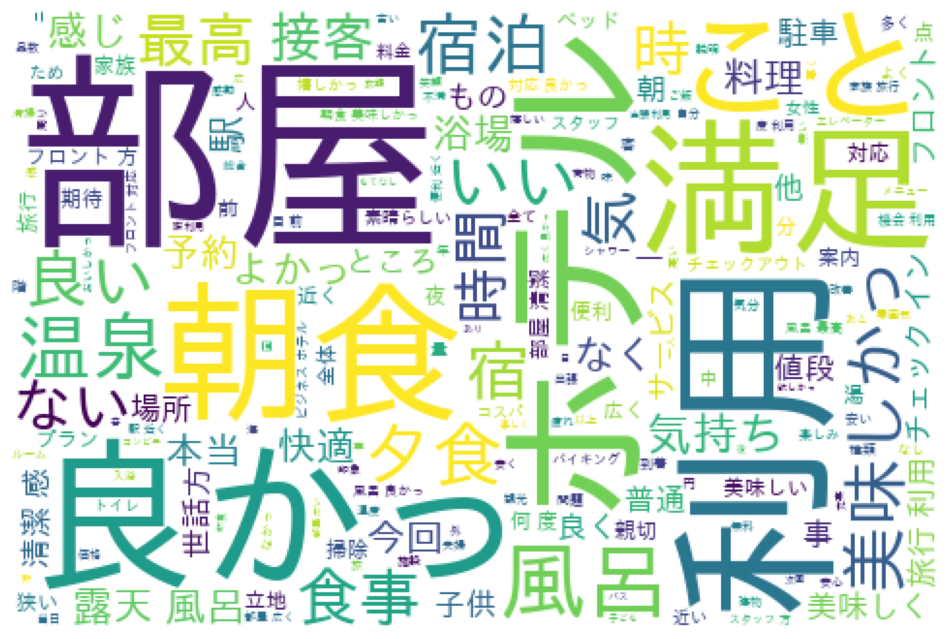

In [25]:
plt.figure(figsize=(12,10))
plt.imshow(result)
plt.axis('off')
plt.show()

# KH coder

In [31]:
# https://zenn.dev/robes/articles/a3e1a6e80efd99

In [32]:
import itertools
sentences_combs = [list(itertools.combinations(sentence[1]["words"],2)) for sentence in df.iterrows()]

In [33]:
words_combs = [[tuple(sorted(words)) for words in sentence] for sentence in sentences_combs]
words_combs[0]

[('世話', '出張')]

In [34]:
target_combs = []
for words_comb in words_combs:
    target_combs.extend(words_comb)
target_combs[:10]

[('世話', '出張'),
 ('普通', '朝食'),
 ('ホテル', '利用'),
 ('便利', '駅'),
 ('近く', '駅'),
 ('便利', '近く'),
 ('利用', '来年'),
 ('新婚', '旅行'),
 ('利用', '新婚'),
 ('利用', '旅行')]

In [37]:
import collections

def make_jaccard_coef_data(combination_sentences):
    
    #codes from https://www.dskomei.com/entry/2019/04/07/021028
    combi_count = collections.Counter(combination_sentences)

    word_associates = []
    for key, value in combi_count.items():
        word_associates.append([key[0], key[1], value])

    word_associates = pd.DataFrame(word_associates, columns=['word1', 'word2', 'intersection_count'])

    words = []
    for combi in combination_sentences:
        words.extend(combi)

    word_count = collections.Counter(words)
    word_count = [[key, value] for key, value in word_count.items()]
    word_count = pd.DataFrame(word_count, columns=['word', 'count'])

    word_associates = pd.merge(
        word_associates,
        word_count.rename(columns={'word': 'word1'}),
        on='word1', how='left'
    ).rename(columns={'count': 'count1'}).merge(
        word_count.rename(columns={'word': 'word2'}),
        on='word2', how='left'
    ).rename(columns={'count': 'count2'}).assign(
        union_count=lambda x: x.count1 + x.count2 - x.intersection_count
    ).assign(jaccard_coef=lambda x: x.intersection_count / x.union_count).sort_values(
        ['jaccard_coef', 'intersection_count'], ascending=[False, False]
    )
    
    return word_associates

jaccard_coef_data = make_jaccard_coef_data(target_combs)

jaccard_coef_data.head(10)

,word1,word2,intersection_count,count1,count2,union_count,jaccard_coef
4532,打ち所,非,1,1,1,1,1.000000
4766,セキュリティ,万全,1,1,1,1,1.000000
5292,削減,経費,1,1,1,1,1.000000
26111,ネギ,生姜,1,1,1,1,1.000000
26457,豆腐,風船,1,1,1,1,1.000000
28073,ジャグジー,不調,1,1,1,1,1.000000
32096,Free,全館,1,1,1,1,1.000000
4779,トースト,フレンチ,1,2,2,3,0.333333
4949,アドベンチャー,ワールド,1,2,2,3,0.333333
5584,念願,白骨,1,2,2,3,0.333333


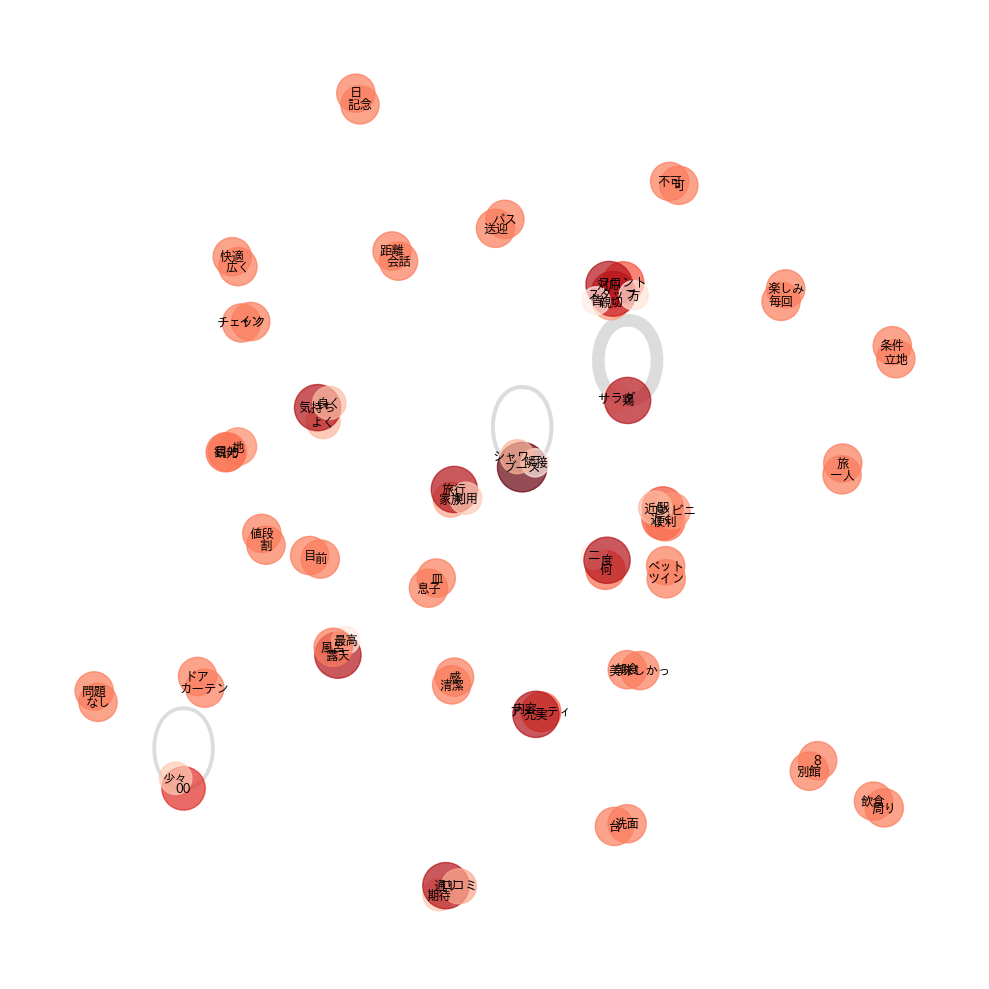

In [59]:
import networkx as nx

# https://qiita.com/petitviolet/items/d66cd7db5b35aec91c35
font_path='/usr/share/fonts/opentype/ipaexfont-gothic/ipaexg.ttf'
font_prop = font_manager.FontProperties(fname=font_path)
# nx.set_fontproperties(font_prop)


def plot_network(
    data,
    edge_threshold=0.,
    fig_size=(15, 15),
    fontfamily="IPAexGothic",
    fontsize=14,
    coefficient_of_restitution=0.15,
    image_file_path=None
):

    nodes = list(set(data['node1'].tolist() + data['node2'].tolist()))
    
    plt.figure(figsize=fig_size)
    
    G = nx.Graph()
    # 頂点の追加
    G.add_nodes_from(nodes)

    # 辺の追加
    # edge_thresholdで枝の重みの下限を定めている
    for i in range(len(data)):
        row_data = data.iloc[i]
        if row_data['weight'] >= edge_threshold:
            G.add_edge(row_data['node1'], row_data['node2'], weight=row_data['weight'])

    # 孤立したnodeを削除
    isolated = [n for n in G.nodes if len([i for i in nx.all_neighbors(G, n)]) == 0]
    for n in isolated:
        G.remove_node(n)

    # k = node間反発係数
    pos = nx.spring_layout(G, k=coefficient_of_restitution)

    pr = nx.pagerank(G)
    # nodeの大きさ
    nx.draw_networkx_nodes(
        G, pos, node_color=list(pr.values()),
        cmap=plt.cm.Reds,
        alpha=0.7,
        node_size=[60000*v for v in pr.values()]
    )

    # 日本語ラベル
    nx.draw_networkx_labels(G, pos, font_size=fontsize, font_family=fontfamily, font_weight="bold")
    
    
    
    # エッジの太さ調節
    edge_width = [d["weight"] * 100 for (u, v, d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="darkgrey", width=edge_width)

    plt.axis('off')
    plt.tight_layout()
    
    if image_file_path:
        plt.savefig(image_file_path, dpi=300)

n_word_lower = 50
edge_threshold=0.025
plot_data = jaccard_coef_data.query(
    'count1 >= {0} and count2 >= {0}'.format(n_word_lower)
).rename(
    columns={'word1': 'node1', 'word2': 'node2', 'jaccard_coef': 'weight'}
)

plot_network(
    data=plot_data,
    edge_threshold=edge_threshold,
    fig_size=(10, 10),
    fontsize=9,
    fontfamily="IPAexGothic",
    coefficient_of_restitution=0.006,
    image_file_path="kh_result"
)

In [57]:
import collections
ct = collections.Counter(target_combs)
ct.most_common()[:10]

[(('露天', '風呂'), 94),
 (('イン', 'チェック'), 65),
 (('感', '清潔'), 60),
 (('広く', '部屋'), 53),
 (('利用', '旅行'), 51),
 (('部屋', '風呂'), 50),
 (('良かっ', '風呂'), 49),
 (('良かっ', '部屋'), 44),
 (('フロント', '対応'), 44),
 (('フロント', '方'), 43)]

In [58]:
df_co = pd.DataFrame([{"1番目" : i[0][0], "2番目": i[0][1], "count":i[1]} for i in ct.most_common()])
df_co.head(20)

,1番目,2番目,count
0,露天,風呂,94
1,イン,チェック,65
2,感,清潔,60
3,広く,部屋,53
4,利用,旅行,51
5,部屋,風呂,50
6,良かっ,風呂,49
7,良かっ,部屋,44
8,フロント,対応,44
9,フロント,方,43


# nlplotを使用

In [21]:
# class PlotFigures:
#   def __init__(self, sample):
#     self.npt        = nlplot.NLPlot(sample, target_col='words')
#     self.stopwords  = self.npt.get_stopword(top_n=0, min_freq=0)
#     self.sample     = sample
    
#   def bar_ngram(self):
#     '''
#     sampleデータをもとに、bar_ngramを作成します。
#     作成された画像ファイルはCFG.filename_baseで指定されたディレクトリ下に作成
#     (以下同様)
#       input  なし
#       output なし
#     '''

#     out = self.npt.bar_ngram(
#         title = CFG.filename_base + " " + 'uni-gram',
#         xaxis_label='word_count',
#         yaxis_label='word',
#         ngram=1,
#         top_n=50,
#         stopwords=self.stopwords
#     )

#     out.show()
#     out.write_image(CFG.filename_base + "_" + "top_0.png",scale=10)

#   def tree_map(self):
#     out = self.npt.treemap(
#         title = CFG.filename_base + " " + 'Tree of Most Common Words',
#         ngram=1,
#         top_n=30,
#         stopwords=self.stopwords,
#     )

#     out.show()
#     out.write_image(CFG.filename_base + "_" + "tree_map.png",scale=10)


#   def word_distribution(self):
#     out = self.npt.word_distribution(
#     title=CFG.filename_base + " " + 'word distribution',
#     xaxis_label='count'
#     )

#     out.show()
#     out.write_image(CFG.filename_base + "_" + "word_distribution.png",scale=10)

#   def word_cloud(self):
#     out = self.npt.wordcloud(
#       #title=CFG.filename_base + " " + 'word cloud',
#       max_words=100,
#       max_font_size=100,
#       colormap='tab20_r',
#       stopwords=self.stopwords,
#     )
#     plt.figure(figsize=(15, 25))
#     plt.imshow(out, interpolation="bilinear")
#     plt.axis("off")
#     plt.savefig(CFG.filename_base + "_" + 'wordcloud.png',dpi = 300)
#     plt.show()

#   def co_network(self):
#     self.npt.build_graph(stopwords=self.stopwords, min_edge_frequency=25)
#     out = self.npt.co_network(
#       title= CFG.filename_base + " " + 'Co-occurrence network',
#       sizing=100,
#       node_size='adjacency_frequency',
#       color_palette='hls',
#       width=1100,
#       height=700,
#       save=False
#     )
    
    
#     out = go.Figure(out)
#     out.show()

#     # iplot(
#     #     out,
#     #     # image = 'png', 
#     #     # filename = CFG.filename_base + " " +  'co_network.png',
#     #     # validate=False
#     # )
#     # # out.show()
#     out.write_image(CFG.filename_base + "_" + "co_network.png",scale=10)
#     return out

#   def fig_sunburst(self):
#     out = self.npt.sunburst(
#       title=CFG.filename_base + " " + 'sunburst chart',
#       colorscale=True,
#       color_continuous_scale='Oryel',
#       width=1000,
#       height=800,
#       save=False
#     )


#     out.show()

#     out.write_image(CFG.filename_base + "_" + "sunburst_chart.png",scale=10)

#     return out


In [ ]:
pf = PlotFigures(df)

In [ ]:
pf.bar_ngram()

100%|██████████| 5553/5553 [00:00<00:00, 146016.65it/s]


In [ ]:
pf.tree_map()

100%|██████████| 5553/5553 [00:00<00:00, 133711.68it/s]


TypeError: ignored

In [ ]:
pf.word_distribution()

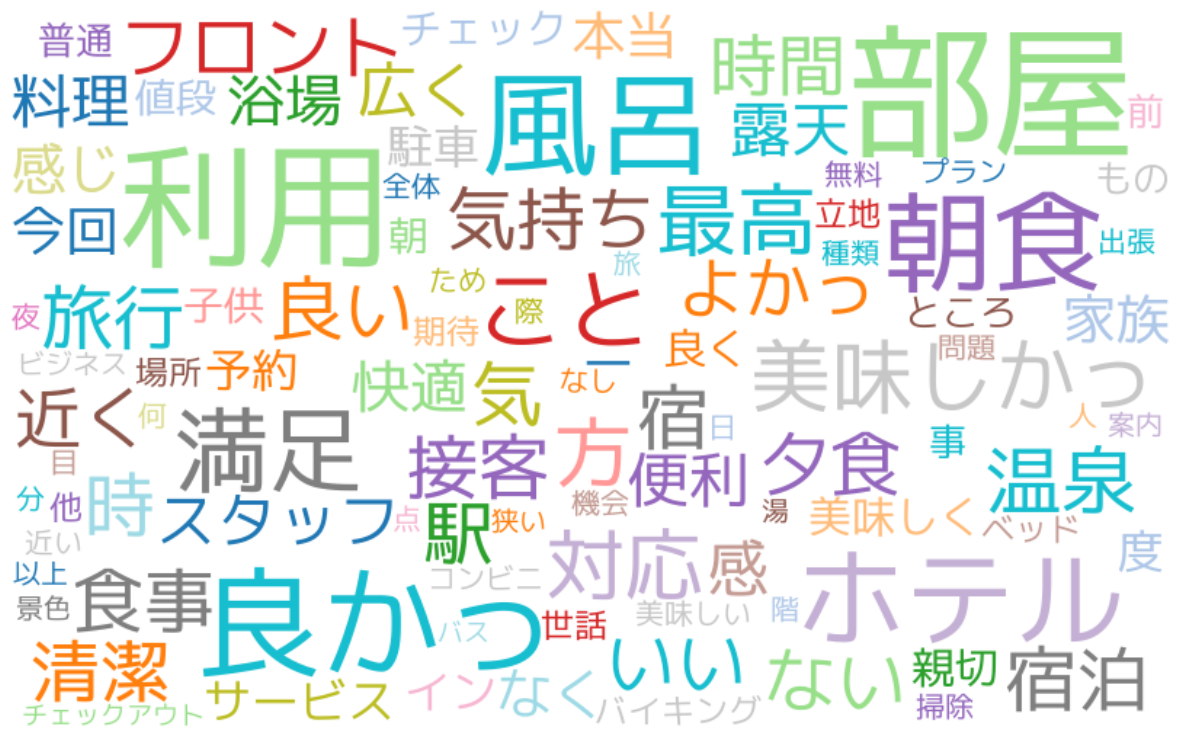

In [ ]:
pf.word_cloud()

In [ ]:
out = pf.co_network()

node_size:29, edge_size:25


In [ ]:
out

In [ ]:
out = pf.fig_sunburst()

In [ ]:
out